In [1]:
from pathlib import Path
import pandas as pd
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.__version__

'1.14.5'

In [3]:
PATH = '../data/coco/'
TRN_PATH = '../data/coco/train2014/'
VAL_PATH = '../data/coco/val2014/'

In [4]:
VAL_CSV = 'val2014.csv'
TRN_CSV = 'train2014.csv'

In [5]:
paths = list(Path(PATH).iterdir())

In [6]:
train = pd.read_csv(PATH+TRN_CSV)
val = pd.read_csv(PATH+VAL_CSV)

In [7]:
train.columns

Index(['img_fname', 'caption1', 'caption2', 'caption3', 'caption4',
       'caption5'],
      dtype='object')

In [8]:
def open_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [9]:
train.head(2)

,img_fname,caption1,caption2,caption3,caption4,caption5
0,COCO_train2014_000000425988.jpg,Two ducks floating on top of a lake with brown...,Two ducks are swimming on the lake next to eac...,Two geese swimming on the water and looking to...,"Two ducks facing the same direction, wading in...",Two geese resting in a body of water
1,COCO_train2014_000000040971.jpg,A long bill bird standing on a beach next to t...,"A small bird with a long, skinny beak walks on...",Long beaked brown bird walking on a beach.,a close up of a bird on a beach near a body of...,A bird with a pink beak is on the beach.


In [10]:
val.head(2)

,img_fname,caption1,caption2,caption3,caption4,caption5
0,COCO_val2014_000000235522.jpg,Three giraffe eating greens in a field next to...,A herd of giraffes eating shrubs on a plain wi...,four giraffes standing or eating in their natu...,A painting of giraffes eating in the tall grass.,Giraffes graze on low shrubs under a cloudy sky.
1,COCO_val2014_000000055299.jpg,A bird is perched on a large rock near the shore.,a large bird perched on a rock on a beach next...,The animal is sitting on the rocks looking at ...,A bird that is sitting on a rock near the water.,The large bird stands on rocks near the beach.


### DATASET

In [11]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SimpleDataset(Dataset):
    def __init__(self, path, df):
        self.path = path
        self.df = df
        self.fnames = self.df.iloc[:, 0].values
        self.ys = self.df.iloc[:, 1:].values
        
    def __getitem__(self, index):
        x = open_image(self.path + self.fnames[index])
        return x, self.ys[index]
    def __len__(self):
        return len(self.fnames)

In [12]:
trn_ds = SimpleDataset(TRN_PATH, train)
val_ds = SimpleDataset(VAL_PATH, val)

['Two ducks floating on top of a lake with brown water.'
 'Two ducks are swimming on the lake next to each other.'
 'Two geese swimming on the water and looking toward the camera.'
 'Two ducks facing the same direction, wading in a pond.'
 'Two geese resting in a body of water']


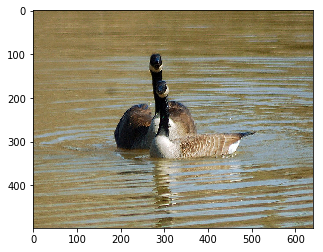

In [13]:
x,y = trn_ds.__getitem__(0)
print(y)
plt.imshow(x)

['Three giraffe eating greens in a field next to lots of trees.'
 'A herd of giraffes eating shrubs on a plain with trees in the background.'
 'four giraffes standing or eating in their natural habitat'
 'A painting of giraffes eating in the tall grass.'
 'Giraffes graze on low shrubs under a cloudy sky.']


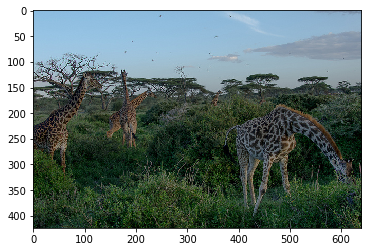

In [14]:
x,y = val_ds.__getitem__(0)
print(y)
plt.imshow(x)

### Image Encoder

We could use this model as part of a broader image caption model. The problem is, it is a large model and running each photo through the network every time we want to test a new language model configuration (downstream) is redundant.

Instead, we can pre-compute the “photo features” using the pre-trained model and save them to file. We can then load these features later and feed them into our model as the interpretation of a given photo in the dataset. It is no different to running the photo through the full VGG model; it is just we will have done it once in advance.

In [15]:
from torchvision import models

In [16]:
resnet = models.resnet18(pretrained=True)

In [17]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### WORD MODEL

Many to Many language model

In [18]:
import torch.nn as nn

In [19]:
cap_cols = train.columns[train.columns.str.contains('caption')]

In [20]:
train_captions = np.array(train[cap_cols]).ravel()
val_captions = np.array(val[cap_cols]).ravel()

In [21]:
print(f"Number of captions: {len(train_captions)+len(val_captions)}")

Number of captions: 134145


In [22]:
train_captions[:5]

array(['Two ducks floating on top of a lake with brown water.',
       'Two ducks are swimming on the lake next to each other.',
       'Two geese swimming on the water and looking toward the camera.',
       'Two ducks facing the same direction, wading in a pond.',
       'Two geese resting in a body of water'], dtype=object)

### Process Text

- Convert all words to lowercase.
- Remove all punctuation.
- Remove all words that are one character or less in length (e.g. ‘a’).
- Remove all words with numbers in them.

smaller vocab

Loaded: 8,092
Vocabulary Size: 8,763

In [23]:
import string, re
from collections import defaultdict

In [24]:
def process_text(s):
    return s.lower().strip('\n').translate(str.maketrans('','',string.punctuation)).split(' ')

In [25]:
captions = np.concatenate((train_captions, val_captions))

In [26]:
vocab = defaultdict(int)
for s in captions:
    for w in process_text(s):
        vocab[w] += 1

In [27]:
len(vocab)

11665

In [28]:
# VOCAB2IDX
vocab2idx = {}
vocab2idx['<pad>'] = len(vocab2idx)
vocab2idx['<start>'] = len(vocab2idx)
vocab2idx['<end>'] = len(vocab2idx)
for i, w in enumerate(vocab):
    vocab2idx[w] = i+3

In [29]:
# IDX2VOCAB
idx2vocab = {}
for w in vocab2idx:
    idx2vocab[vocab2idx[w]] = w

In [30]:
processed_captions = [process_text(cap) for cap in captions]

In [31]:
max_len = 0
for cap in processed_captions:
    max_len = max(len(cap), max_len)

In [32]:
max_len

50

In [33]:
processed_captions[0]

['two',
 'ducks',
 'floating',
 'on',
 'top',
 'of',
 'a',
 'lake',
 'with',
 'brown',
 'water']

In [34]:
vocab2idx

{'<pad>': 0,
 '<start>': 1,
 '<end>': 2,
 'two': 3,
 'ducks': 4,
 'floating': 5,
 'on': 6,
 'top': 7,
 'of': 8,
 'a': 9,
 'lake': 10,
 'with': 11,
 'brown': 12,
 'water': 13,
 'are': 14,
 'swimming': 15,
 'the': 16,
 'next': 17,
 'to': 18,
 'each': 19,
 'other': 20,
 'geese': 21,
 'and': 22,
 'looking': 23,
 'toward': 24,
 'camera': 25,
 'facing': 26,
 'same': 27,
 'direction': 28,
 'wading': 29,
 'in': 30,
 'pond': 31,
 'resting': 32,
 'body': 33,
 'long': 34,
 'bill': 35,
 'bird': 36,
 'standing': 37,
 'beach': 38,
 'ocean': 39,
 'small': 40,
 'skinny': 41,
 'beak': 42,
 'walks': 43,
 'beaked': 44,
 'walking': 45,
 'close': 46,
 'up': 47,
 'near': 48,
 'pink': 49,
 'is': 50,
 'birds': 51,
 'sitting': 52,
 'red': 53,
 'towel': 54,
 'shower': 55,
 'pole': 56,
 'bathroom': 57,
 'rod': 58,
 'hanging': 59,
 'restroom': 60,
 'one': 61,
 'curtain': 62,
 'another': 63,
 'wash': 64,
 'cloth': 65,
 'draped': 66,
 'over': 67,
 'perching': 68,
 'hung': 69,
 'rack': 70,
 'many': 71,
 'elephants':

### padding

pad at the beginning

In [35]:
def pad_prep_x(cap, max_len=50):
    pad = ['<pad>' for i in range(max_len - len(cap))]
    pad = ['<start>'] + cap + pad
    return [vocab2idx[w] for w in pad], len(cap)+1

def pad_prep_y(cap, max_len=50):
    pad = ['<pad>' for i in range(max_len - len(cap))]
    pad = cap + ['<end>'] + pad
    return [vocab2idx[w] for w in pad]

def prep_y(cap):
    return [vocab2idx[w] for w in cap] +  [vocab2idx['<end>']]

In [36]:
xs = [np.array(pad_prep_x(cap)) for cap in processed_captions]

In [37]:
x, xlen = zip(*xs)

In [38]:
y = [np.array(pad_prep_y(cap)) for cap in processed_captions]

In [39]:
x = np.array(x)
xlen = np.array(list(xlen))
y = np.array(y)

In [40]:
x[1]

array([ 1,  3,  4, 14, 15,  6, 16, 10, 17, 18, 19, 20,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [41]:
y[1]

array([ 3,  4, 14, 15,  6, 16, 10, 17, 18, 19, 20,  2,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [42]:
y_lengths = xlen

In [43]:
D = 5
emb_pad = nn.Embedding(1, D)
emb_words = nn.Embedding(len(vocab2idx), D)

emb_pad.weight.requires_grad = False
emb_pad.weight.zero_()
emb_words.weight.requires_grad = True

In [44]:
emb_words.weight

Parameter containing:
tensor([[ 0.1687,  0.2413,  0.4323, -0.9856, -1.8642],
        [-0.3016, -0.3579,  0.9212,  0.6365,  0.4569],
        [-1.1199,  2.0578, -0.5110, -0.6344, -1.4616],
        ...,
        [-1.5873,  1.9796, -0.4351,  0.9406, -1.6554],
        [ 0.7682, -0.8217,  0.7012, -0.5334,  1.2172],
        [-1.0483, -0.3386,  0.4412, -0.3033, -0.0020]])

In [45]:
emb_pad.weight

Parameter containing:
tensor([[ 0.,  0.,  0.,  0.,  0.]])

In [46]:
emb_pad.weight.requires_grad, emb_words.weight.requires_grad

(False, True)

In [47]:
x[0]

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [48]:
x.shape

(134145, 51)

In [49]:
y[0]

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  2,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [50]:
len(x)

134145

In [51]:
len(y)

134145

### Word Model

In [52]:
input_size = D
hidden_size = 100
rnn = nn.RNN(input_size, hidden_size, bias=False)

In [53]:
#sample_batch: seq_len, batch_size, input_size
import torch
sample_x = torch.LongTensor(x[:3])
sample_y = torch.LongTensor(np.concatenate(y[:3]).ravel())

In [54]:
x, y

(array([[  1,   3,   4, ...,   0,   0,   0],
        [  1,   3,   4, ...,   0,   0,   0],
        [  1,   3,  21, ...,   0,   0,   0],
        ...,
        [  1,  16,  77, ...,   0,   0,   0],
        [  1, 300,  22, ...,   0,   0,   0],
        [  1,  71,  79, ...,   0,   0,   0]]),
 array([[    3,     4,     5, ...,     0,     0,     0],
        [    3,     4,    14, ...,     0,     0,     0],
        [    3,    21,    15, ...,     0,     0,     0],
        ...,
        [   16,    77,     8, ...,     0,     0,     0],
        [  300,    22, 11566, ...,     0,     0,     0],
        [   71,    79,    30, ...,     0,     0,     0]]))

In [55]:
len(x)

134145

In [56]:
y.shape

(134145, 51)

In [57]:
class WordDataset(Dataset):
    def __init__(self, x, y, y_lengths):
        self.x = x
        self.y = y
        self.y_lengths = y_lengths
    
    def __getitem__(self, index):
        return torch.LongTensor(self.x[index]), torch.LongTensor(self.y[index]), #self.y_lengths[index]
    
    def __len__(self):
        return len(self.x)

In [58]:
word_ds = WordDataset(x, y, y_lengths)
word_dl = DataLoader(word_ds, batch_size=100)

In [59]:
sample_x, sample_y = next(iter(word_dl))

In [60]:
sample_x.shape, sample_y.shape

(torch.Size([100, 51]), torch.Size([100, 51]))

In [61]:
D = 5
emb_pad = nn.Embedding(1, D)
emb_words = nn.Embedding(len(vocab2idx), D)

emb_pad.weight.requires_grad = False
emb_pad.weight.zero_()
emb_words.weight.requires_grad = True

In [62]:
TORCH_TENSORS = (torch.FloatTensor, torch.LongTensor, torch.Tensor)

class WordModel(nn.Module):
    def __init__(self, D, hidden_size, vocab_len = len(vocab2idx)):
        """
        Word Model can be extended and be more sophisticated
        """
        super(WordModel, self).__init__()
        # INIT EMBEDDINGS
        self.D = D
        self.emb_words = nn.Embedding(len(vocab2idx), self.D)
        self.emb_words.weight.requires_grad = True
        
        # RNN
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(self.D, self.hidden_size, num_layers=1)
        self.lin = nn.Linear(self.hidden_size, vocab_len)
        
    def forward(self, sample_x, hidden=None):
        """
        For Image Caption Model <start>, image feature activations
        sample_x: arbitrary length sequence
        hidden:  (num_layers * num_directions, batch, hidden_size):
        """
          
        batch = self.emb_words(sample_x)
        # seq_len, batch_size, input_size=D            
        batch = batch.permute(1,0,2)
        # rnn forward
        if isinstance(hidden, TORCH_TENSORS): out_hidden, hidden_n = self.rnn(batch, hidden)
        else: out_hidden, hidden_n = self.rnn(batch)
        # output: seq_len, batch_size, vocab_len
        out = self.lin(out_hidden)
        if self.training:
            return out
        else:
            return self.lin(hidden_n), hidden_n

In [63]:
wordmodel = WordModel(5, 100).cuda()

In [64]:
wordmodel.train()

WordModel(
  (emb_words): Embedding(11668, 5)
  (rnn): RNN(5, 100)
  (lin): Linear(in_features=100, out_features=11668, bias=True)
)

In [65]:
wordmodel.training

True

In [66]:
sample_x.shape

torch.Size([100, 51])

In [67]:
sample_x

tensor([[  1,   3,   4,  ...,   0,   0,   0],
        [  1,   3,   4,  ...,   0,   0,   0],
        [  1,   3,  21,  ...,   0,   0,   0],
        ...,
        [  1,   9,  53,  ...,   0,   0,   0],
        [  1,   9,  76,  ...,   0,   0,   0],
        [  1,   9,  53,  ...,   0,   0,   0]])

In [68]:
sample_y[-1]

tensor([   9,   53,  118,   50,   52,    6,  113,   59,  254,    2,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])

In [69]:
import torch.nn.functional as F
def lang_loss(out, y, y_lengths):
    """Calculate loss excluding padding elements"""
    out = out.permute(1,0,2)
    bs = out.shape[0]
    batch_loss = 0
    for l, out_i, y_i in zip(y_lengths, out, y):
        batch_loss += F.nll_loss(F.log_softmax(out_i[:l], dim=0), y_i[:l], size_average=False)
    return batch_loss/bs

In [70]:
def lang_loss2(out, y):
    out = out.permute(1,0,2)[y != 0, :]
    y = y[y != 0]
    return F.nll_loss(F.log_softmax(out, dim=0), y, size_average=True)

In [71]:
test_x = "i know"

In [88]:
def create_test_tensor(test_x):
    return torch.tensor([vocab2idx[w] for w in process_text(test_x)])[None, :]

def sample_sentence(model, input_text, k=5, sentence_length=None):
    """
    at the moment random top k sampling
    input_text: arbitrary length input to start sampling from
    """
    model = model.eval()
    generated = input_text

    # initial input - arbitrary size
    input_text = create_test_tensor(input_text)
    test_out, hidden_prev = model(input_text.cuda())
    next_idx = torch.argmax(test_out.view(-1)).item()
    next_word = idx2vocab[next_idx]
    
    if sentence_length is not None:
        for i in range(sentence_length):
            test_out_np = (test_out.view(-1)).cpu().detach().numpy()
            topk = np.argsort(test_out_np)[::-1][:k]
            next_idx = np.random.choice(topk)
            next_word = idx2vocab[next_idx]
            generated += ' ' + next_word
            test_x = create_test_tensor(next_word)
            test_out, hidden_prev = model(test_x.cuda())
    else:
        while next_word != '<end>':
            test_out_np = (test_out.view(-1)).cpu().detach().numpy()
            topk = np.argsort(test_out_np)[::-1][:k]
            next_idx = np.random.choice(topk)
            next_word = idx2vocab[next_idx]
            generated += ' ' + next_word
            test_x = create_test_tensor(next_word)
            test_out, hidden_prev = model(test_x.cuda())
    
    return generated

In [73]:
sample_sentence(wordmodel, 'white rabbit', 40)

'white rabbit binders ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic ceramic'

### Training

In [76]:
trn_len = 120000
trn_ds = WordDataset(x[:trn_len], y[:trn_len], y_lengths[:trn_len])
trn_dl = DataLoader(trn_ds, batch_size=500)
val_ds = WordDataset(x[trn_len:], y[trn_len:], y_lengths[trn_len:])
val_dl = DataLoader(trn_ds, batch_size=500)

In [82]:
# PyTorch v 0.4
# https://pytorch.org/2018/04/22/0_4_0-migration-guide.html
import torch.nn.functional as F
from tqdm import tqdm

#for restoring model
TORCH_CUDA_TENSOR = (
        torch.cuda.FloatTensor,
        torch.cuda.DoubleTensor,
        torch.cuda.HalfTensor,
        torch.cuda.ByteTensor,
        torch.cuda.CharTensor,
        torch.cuda.ShortTensor,
        torch.cuda.IntTensor,
        torch.cuda.LongTensor
)

def get_optimizer(model, optim, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = optim(parameters, lr=lr, weight_decay=wd)
    return optim
        
##lrfind
def save_model(m, p): torch.save(m.state_dict(), p)

def load_model(m, p): m.load_state_dict(torch.load(p))

# Average meter counter
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count # moving average


        
#class Classifier: main classifier class

### TODO Different Child Classifiers: ImageClassifier(Classifier) 
# implement : https://distill.pub/2017/feature-visualization/

class Classifier:
    def __init__(self, model, optim, crit, metric, gpu=1):
        """
        Initialize classifier with model, optimizer, criterion and metric
        """
        
        ### TODO: Add early stopping
        self.model = model
        self.epoch_counter = 0  # counts number of epochs
        self.use_cuda = torch.cuda.is_available()  # enable cuda if gpu available
        self.gpu = gpu  # gpu id to train on
        self.optim = optim  # optimizer to use
        self.crit = crit  # loss function to use
        self.metric = metric  # metric to use
        self.loss_metric_summary = [] # summary for training
        self.device = torch.device(f"cuda:{self.gpu}" if self.use_cuda else "cpu")


    def _validate_epoch(self, val_dl):
        """
        Validate by self._criterion
        """
        losses = AverageMeter()  # reset for epoch
        metrics = AverageMeter()  # reset for epoch
        batch_size = val_dl.batch_size
        
        with torch.no_grad():
            for x, y in val_dl:
                if isinstance(x, list): x=[xi.to(self.device) for xi in x]
                else: x = [x.to(self.device)]
                y = y.to(self.device)

                # forward
                out = self.model(*x)

                # compute and update loss
                loss = self.crit(out, y)
                losses.update(loss.item(), batch_size)

                # compute and update metric
                metric = self.metric(out, y)
                metrics.update(metric.item(), batch_size)

        return losses.avg, metrics.avg

    def _train_epoch(self, trn_dl, optimizer):
        """
        Optimize by self._criterion and self.optimizer
        """
        losses = AverageMeter()  # reset for epoch
        metrics = AverageMeter()  # reset for epoch
        batch_size = trn_dl.batch_size
        
        for x, y in tqdm(trn_dl):
            if isinstance(x, list): x=[xi.to(self.device) for xi in x]
            else: x = [x.to(self.device)]
            y = y.to(self.device)
                
            # forward
            out = self.model(*x)

            # compute and update loss
            loss = self.crit(out, y)
            losses.update(loss.item(), batch_size)
            
            # TODO : allow multiple metrics
            metric = self.metric(out, y) 
            metrics.update(metric.item(), batch_size)

            # backprop - update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return losses.avg, metrics.avg

    def _run_epoch(self, trn_dl, val_dl, optimizer):
        """
        Run a single epoch and print out loss and metric
        """
        self.model.train() # train mode
        train_loss, train_metric = self._train_epoch(trn_dl, optimizer)

        #self.model.eval() # eval mode (Batchnorm, Dropout, ...)
        val_loss, val_metric = self._validate_epoch(val_dl)
        
        self.epoch_counter += 1
        
        print(f"Epoch: {self.epoch_counter}")
        print(f"{self.crit.__name__} : [{round(train_loss, 3)}, {round(val_loss, 3)}]\
        {self.metric.__name__} : [{round(train_metric, 3)}, {round(val_metric, 3)}]")
        print()

        return (train_loss, val_loss, train_metric, val_metric)
    
    def train(self, lr, wd, trn_dl, val_dl, epochs):
        """
        Train for n eopchs
        """
        # optimizer
        optimizer = get_optimizer(self.model, self.optim, lr=lr, wd=wd)
        
        if self.use_cuda:
            self.model.cuda(self.gpu)
        
        for epoch in range(epochs):
            loss_metric = self._run_epoch(trn_dl, val_dl, optimizer)
            self.loss_metric_summary.append([self.epoch_counter, loss_metric])
        

    def lr_find(self, trn_dl, lr_low=1e-5, lr_high=1, epochs=2, n_iter=100):
        losses = []
        path = "/tmp/mode_tmp.pth"
        save_model(self.model, str(path))
        iterations = epochs * len(trn_dl)
        delta = (lr_high - lr_low)/iterations
        lrs = [lr_low + i*delta for i in range(iterations)] # increase linearly
        self.model.train()
        ind = 0
        for i in tqdm(range(epochs)):
            for x, y in tqdm(trn_dl):
                # changing learning rate at each iteration
                optimizer = get_optimizer(self.model, self.optim, lr=lrs[ind])
                if isinstance(x, list): x=[xi.to(self.device) for xi in x]
                else: x = [x.to(self.device)]
                y = y.to(self.device) 
                out = self.model(*x)
                loss = self.crit(out, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
                ind +=1

        load_model(self.model, path)
        return lrs, losses
           
        
    def restore_model(self, path):
        """
        Restore a model parameters from the given path
        Inputs:
            model_path (str): The path to the model to restore
        https://github.com/pytorch/pytorch/issues/2830
        """
        state = torch.load(path)
        self.model.load_state_dict(state['state_dict'])
        self.optimizer.load_state_dict(state['optimizer'])
        self.epoch_counter = state['epoch']  # counts number of epochs
        
        if self.use_cuda: 
            ### add other tensor types
            for state in self.optimizer.state.values():
                for k, v in state.items():
                    if isinstance(v, TORCH_CUDA_TENSOR):
                        state[k] = v.cuda(self.gpu)

    def save_model(self, path):
        # FIX SAVE MODEL WITH get_optimizer
        state = {
            'epoch': self.epoch_counter,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        torch.save(state, path)

    def predict(self, test_dl):
        # eval mode
        self.model.eval()
        preds = []
        with torch.no_grad():
            for x in enumerate(test_dl):
                if self.use_cuda:
                    if isinstance(x, list): x=[xi.to(self.device) for xi in x]
                    else: x = [x.to(self.device)]
                        
            out = self.model(*x)
            out = out.items().to(torch.device("cpu"))
            preds.append(out)
        return preds
    
    def plot_loss_metric(self):
        losses = [lm[:2] for _, lm in self.loss_metric_summary]
        metrics = [lm[2:] for _, lm in self.loss_metric_summary]
        losses = list(enumerate(losses))
        metrics = list(enumerate(metrics))
        trn_loss, val_loss = zip(*losses)
        trn_metric, val_metric = zip(*metrics)

        fig, ax = plt.subplots(2,1, figsize=(18, 15))
        titles = (f"Loss Curve : {self.crit.__name__}",f"Metric Curve : {self.metric.__name__}")
        
        for axes, (trn_stat, val_stat), tit in zip(ax.flatten(),
                                                  ((trn_loss, val_loss), (trn_metric, val_metric)),titles):
            axes.set_title(tit, fontdict={'fontsize':20})
            axes.plot(trn_stat, val_stat)
            axes.legend(("train", "val"), fontsize='xx-large')

In [83]:
D = 5
optim = torch.optim.Adam
model = WordModel(D, 100).cuda()
crit = lang_loss2
metric = lang_loss2
classifier = Classifier(model, optim, crit, metric, gpu=0)

In [79]:
#lrs, losses = classifier.lr_find(trn_dl, epochs=1)
#plt.plot(lrs[:10], losses[:10])

In [84]:
classifier.train(0.02, 0, trn_dl, val_dl, 10)

  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 1
lang_loss2 : [7.245, 6.933]        lang_loss2 : [7.245, 6.933]



  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 2
lang_loss2 : [6.86, 6.815]        lang_loss2 : [6.86, 6.815]



  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 3
lang_loss2 : [6.76, 6.756]        lang_loss2 : [6.76, 6.756]



  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 4
lang_loss2 : [6.717, 6.732]        lang_loss2 : [6.717, 6.732]



  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 5
lang_loss2 : [6.691, 6.728]        lang_loss2 : [6.691, 6.728]



  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 6
lang_loss2 : [6.679, 6.693]        lang_loss2 : [6.679, 6.693]



  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 7
lang_loss2 : [6.66, 6.702]        lang_loss2 : [6.66, 6.702]



  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 8
lang_loss2 : [6.656, 6.688]        lang_loss2 : [6.656, 6.688]



  0%|          | 0/240 [00:00<?, ?it/s]

Epoch: 9
lang_loss2 : [6.649, 6.677]        lang_loss2 : [6.649, 6.677]



100%|██████████| 240/240 [02:04<00:00,  1.92it/s]


Epoch: 10
lang_loss2 : [6.64, 6.661]        lang_loss2 : [6.64, 6.661]



In [156]:
save_model(classifier.model, 'wordmodel')

In [90]:
sample_sentence(classifier.model, 'lady', 30)

'lady pause dwindling coat hers pitched hill attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching kayak buffaloes motel'

In [91]:
sample_sentence(classifier.model, 'birds', 30)

'birds medallion blown spoked hill attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching'

In [94]:
sample_sentence(classifier.model, '<start>', 30)

'<start> hill attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching kayak buffaloes motel poodle attaching kayak buffaloes motel'

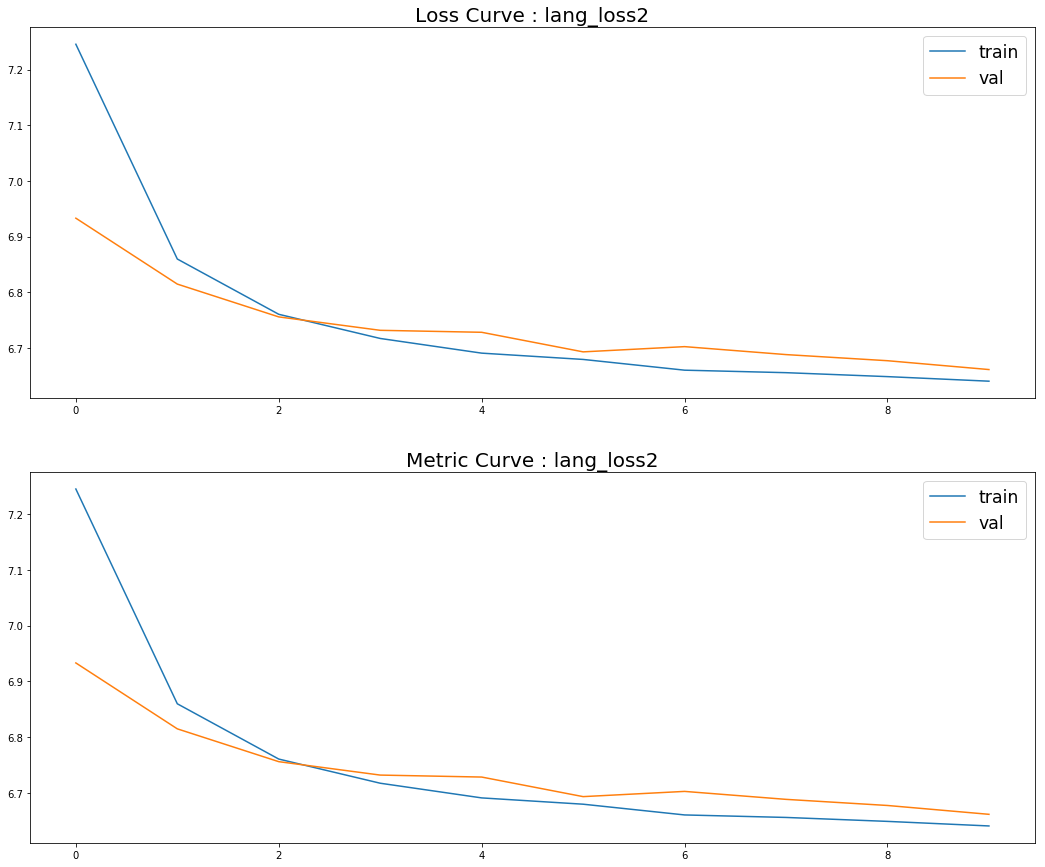

In [93]:
classifier.plot_loss_metric()

In [154]:
sample_sentence(classifier.model, '<start>', 5, 100)

'<start> put affection devices blown sparse fourth fences automobiles dont put soon sniff netting provide cupcakes upon fencing captures pjs mitt duty buggy focused wheat focused buggy roads linked device because chains put soon push shears fences featuring automobiles capped slow fetched fetched disorganized automobiles capped slow fetched disorganized march flatbed gardens gardens bales would formations patrons blown fourth buggy danger charging mean incredibly camel nibbles buggy roads graphic arc quarters returns cupcakes assortment cupcakes assortment puppies focused dust keeper featured time entire plank duty mark fences capped put soon predators duty mark puppies featured possibly blown dust keeper focused fourth'